# Caso Práctico: _Support Vector Machine (SVM)_

## Conjunto de datos: Detección de URLs maliciosas

### Descripción
The Web has long become a major platform for online criminal activities. URLs are used as the main vehicle in this domain. To counter this issues security community focused its efforts on developing techniques for mostly blacklisting of malicious URLs.

While successful in protecting users from known malicious domains, this approach only solves part of the problem. The new malicious URLs that sprang up all over the web in masses commonly get a head start in this race. Besides that, Alexa ranked, trusted websites may convey compromised fraudulent URLs called defacement URL.

We study mainly five different types of URLs:

**Benign URLs**: Over 35,300 benign URLs were collected from Alexa top websites. The domains have been passed through a Heritrix web crawler to extract the URLs. Around half a million unique URLs are crawled initially and then passed to remove duplicate and domain only URLs. Later the extracted URLs have been checked through Virustotal to filter the benign URLs.

**Spam URLs**: Around 12,000 spam URLs were collected from the publicly available WEBSPAM-UK2007 dataset.

**Phishing URLs**: Around 10,000 phishing URLs were taken from OpenPhish which is a repository of active phishing sites.

**Malware URLs**: More than 11,500 URLs related to malware websites were obtained from DNS-BH which is a project that maintain list of malware sites.

**Defacement URLs**: More than 45,450 URLs belong to Defacement URL category. They are Alexa ranked trusted websites hosting fraudulent or hidden URL that contains both malicious web pages.

### Descarga de los ficheros de datos
https://www.unb.ca/cic/datasets/url-2016.html

### Referencias adicionales sobre el conjunto de datos
_Mohammad Saiful Islam Mamun, Mohammad Ahmad Rathore, Arash Habibi Lashkari, Natalia Stakhanova and Ali A. Ghorbani, "Detecting Malicious URLs Using Lexical Analysis", Network and System Security, Springer International Publishing, P467--482, 2016._

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

In [2]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el pipeline sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='.*invalid value encountered in subtract.*')

## Funciones auxiliares

In [6]:
# TODO: Construcción de una función que realice el particionado completo (train, val y test)

def split_data(df, target_column, train_size=0.7, val_size=0.15, test_size=0.15, random_state=None):
    """
    Particiona el conjunto de datos en train, validation y test.

    Parameters:
    - df: DataFrame que contiene los datos.
    - target_column: nombre de la columna objetivo.
    - train_size: proporción del conjunto de entrenamiento.
    - val_size: proporción del conjunto de validación.
    - test_size: proporción del conjunto de prueba.
    - random_state: semilla para la reproducibilidad.

    Returns:
    - X_train: características del conjunto de entrenamiento.
    - X_val: características del conjunto de validación.
    - X_test: características del conjunto de prueba.
    - y_train: etiquetas del conjunto de entrenamiento.
    - y_val: etiquetas del conjunto de validación.
    - y_test: etiquetas del conjunto de prueba.
    """
    
    # Separar características y etiquetas
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Dividir en train y temp
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, random_state=random_state)
    
    # Calcular el tamaño de validación basado en el tamaño del conjunto temporal
    val_ratio = val_size / (val_size + test_size)
    
    # Dividir el conjunto temporal en validación y prueba
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=val_ratio, random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Ejemplo de uso
# df = pd.read_csv('ruta_al_archivo.csv')  # Carga tus datos aquí
# target_column = 'tipo_url'  # Reemplaza esto con el nombre real de tu columna objetivo
# X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, target_column)


In [4]:
# Representación gráfica del límite de decisión
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

## 1. Lectura del conjunto de datos

In [8]:
df = pd.read_csv("../../datasets/Phishing.csv")

## 2. Visualización preliminar de la información

In [ ]:
# TODO usa head, describe, info, ...

In [9]:
print(df.head())

   Querylength  domain_token_count  path_token_count  avgdomaintokenlen  \
0            0                   2                12                5.5   
1            0                   3                12                5.0   
2            2                   2                11                4.0   
3            0                   2                 7                4.5   
4           19                   2                10                6.0   

   longdomaintokenlen  avgpathtokenlen  tld  charcompvowels  charcompace  \
0                   8         4.083334    2              15            7   
1                  10         3.583333    3              12            8   
2                   5         4.750000    2              16           11   
3                   7         5.714286    2              15           10   
4                   9         2.250000    2               9            5   

   ldl_url  ...  SymbolCount_FileName  SymbolCount_Extension  \
0        0  ...             

In [10]:
print(df.describe())

        Querylength  domain_token_count  path_token_count  avgdomaintokenlen  \
count  15367.000000        15367.000000      15367.000000       15367.000000   
mean       3.446021            2.543698          8.477061           5.851956   
std       14.151453            0.944938          4.660250           2.064581   
min        0.000000            2.000000          0.000000           1.500000   
25%        0.000000            2.000000          5.000000           4.500000   
50%        0.000000            2.000000          8.000000           5.500000   
75%        0.000000            3.000000         11.000000           6.666666   
max      173.000000           19.000000         68.000000          29.500000   

       longdomaintokenlen  avgpathtokenlen           tld  charcompvowels  \
count        15367.000000     15096.000000  15367.000000    15367.000000   
mean            10.027461         5.289936      2.543698       12.659986   
std              5.281090         3.535097      0.9

In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15367 entries, 0 to 15366
Data columns (total 80 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Querylength                      15367 non-null  int64  
 1   domain_token_count               15367 non-null  int64  
 2   path_token_count                 15367 non-null  int64  
 3   avgdomaintokenlen                15367 non-null  float64
 4   longdomaintokenlen               15367 non-null  int64  
 5   avgpathtokenlen                  15096 non-null  float64
 6   tld                              15367 non-null  int64  
 7   charcompvowels                   15367 non-null  int64  
 8   charcompace                      15367 non-null  int64  
 9   ldl_url                          15367 non-null  int64  
 10  ldl_domain                       15367 non-null  int64  
 11  ldl_path                         15367 non-null  int64  
 12  ldl_filename      

In [13]:
# TODO De la clase y: "URL_Type_obf_Type", obtén el número etiquetadas como phihing y como bening
url_counts = df['URL_Type_obf_Type'].value_counts()

url_counts

URL_Type_obf_Type
benign      7781
phishing    7586
Name: count, dtype: int64

In [23]:
# TODO Comprobación de si existen valores nulos
null_counts = df['URL_Type_obf_Type'].isnull().sum()
null_counts

np.int64(0)

In [22]:
# TODO Comprobación de la existencia de valores infinitos
infinite_values = df.isin([float('inf'), float('-inf')]).sum()
print(infinite_values[infinite_values > 0])

argPathRatio    9
dtype: int64


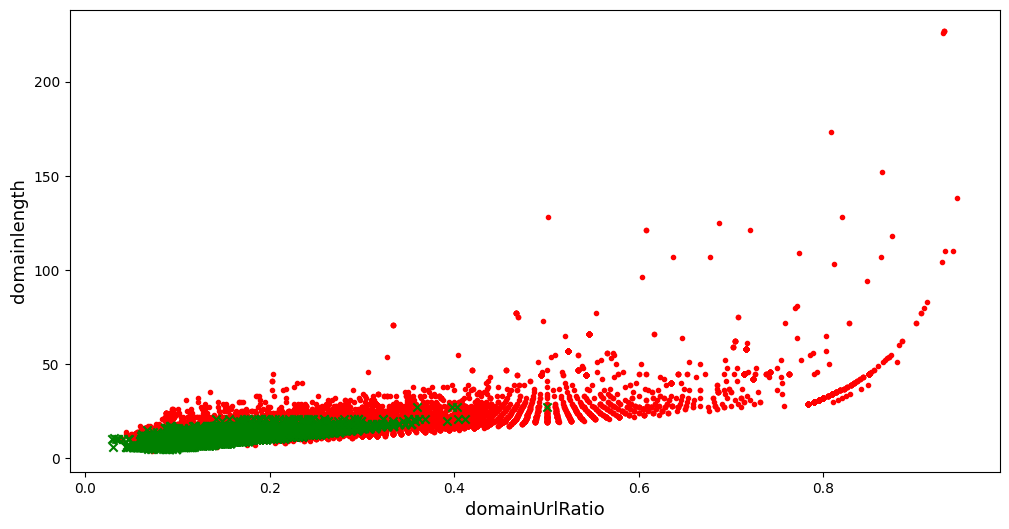

In [18]:
# Ejemplo de representación gráfica de dos características
plt.figure(figsize=(12, 6))
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "phishing"], df["domainlength"][df['URL_Type_obf_Type'] == "phishing"], c="r", marker=".")
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "benign"], df["domainlength"][df['URL_Type_obf_Type'] == "benign"], c="g", marker="x")
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()

## 3. División del conjunto de datos

In [24]:
# TODO División del conjunto de datos (train, val y set)
target_column = 'URL_Type_obf_Type'  # Reemplaza esto con el nombre real de tu columna objetivo
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df, target_column)

In [ ]:
# TODO en los tres subconjuntos, separa las Xs de la y

## 4. Preparación del conjunto de datos

In [31]:
# TODO Elimina el atributo que tiene valores infinitos

numeric_columns = df.select_dtypes(include=[np.float64, np.float32]).columns

# Identificar las columnas que tienen valores infinitos
inf_columns = [col for col in numeric_columns if np.isinf(df[col]).any()]

# Eliminar las columnas que contienen valores infinitos
df_cleaned = df.drop(columns=inf_columns)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_cleaned, target_column)

In [32]:
# TODO Rellena los valores nulos con la mediana (usa SimpleImputer) para todos los subconjuntos
from sklearn.impute import SimpleImputer

# Crear el imputador que usará la mediana
imputer = SimpleImputer(strategy='median')

# Ajustar y transformar el conjunto de entrenamiento
X_train_imputed = imputer.fit_transform(X_train)

# Transformar los conjuntos de validación y prueba
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Convertir los arrays de vuelta a DataFrames (opcional, pero recomendado para mantener la estructura)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_val_imputed = pd.DataFrame(X_val_imputed, columns=X_val.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)


Valores nulos en X_train después de imputar:
Querylength              0
domain_token_count       0
path_token_count         0
avgdomaintokenlen        0
longdomaintokenlen       0
                        ..
Entropy_Domain           0
Entropy_DirectoryName    0
Entropy_Filename         0
Entropy_Extension        0
Entropy_Afterpath        0
Length: 78, dtype: int64

Valores nulos en X_val después de imputar:
Querylength              0
domain_token_count       0
path_token_count         0
avgdomaintokenlen        0
longdomaintokenlen       0
                        ..
Entropy_Domain           0
Entropy_DirectoryName    0
Entropy_Filename         0
Entropy_Extension        0
Entropy_Afterpath        0
Length: 78, dtype: int64

Valores nulos en X_test después de imputar:
Querylength              0
domain_token_count       0
path_token_count         0
avgdomaintokenlen        0
longdomaintokenlen       0
                        ..
Entropy_Domain           0
Entropy_DirectoryName    0
Entrop

In [33]:
# TODO Realiza el preprocesamiento que consideres (como el escalado de valores)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Crear un pipeline de preprocesamiento
pipeline = Pipeline([
    ('scaler', StandardScaler())  # Escalador
])

# Ajustar y transformar los conjuntos de datos
X_train_scaled = pipeline.fit_transform(X_train_imputed)
X_val_scaled = pipeline.transform(X_val_imputed)
X_test_scaled = pipeline.transform(X_test_imputed)

Estadísticas de X_train escalado:
        Querylength  domain_token_count  path_token_count  avgdomaintokenlen  \
count  1.075600e+04        1.075600e+04      1.075600e+04       1.075600e+04   
mean  -1.882714e-17       -1.849684e-16     -5.813291e-17      -2.510285e-17   
std    1.000046e+00        1.000046e+00      1.000046e+00       1.000046e+00   
min   -2.408348e-01       -5.734216e-01     -1.825996e+00      -2.092772e+00   
25%   -2.408348e-01       -5.734216e-01     -7.491007e-01      -6.532089e-01   
50%   -2.408348e-01       -5.734216e-01     -1.029638e-01      -1.562169e-01   
75%   -2.408348e-01        4.659654e-01      5.431731e-01       3.864751e-01   
max    1.208160e+01        1.709616e+01      9.158332e+00       1.134315e+01   

       longdomaintokenlen  avgpathtokenlen           tld  charcompvowels  \
count        1.075600e+04     1.075600e+04  1.075600e+04    1.075600e+04   
mean        -1.387263e-17    -9.578719e-18 -1.849684e-16   -2.444225e-17   
std          1.00

In [42]:
# TODO Transforma el resultado a un DataFrame de Pandas
X_train_prep = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
X_val_prep = pd.DataFrame(X_val_scaled, columns=X_val_imputed.columns)
X_test_prep = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)

In [43]:
X_train_prep.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_Directoryname,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath
0,-0.240835,-0.573422,-0.749101,-0.893136,-0.945333,0.696915,-0.573422,0.390221,0.252688,-0.409775,...,-0.045725,-0.437193,-0.220519,-0.331124,-1.026003,1.043004,0.177516,0.062739,-0.534297,-0.422130
1,3.463020,-0.573422,0.973931,-0.173355,-0.385185,2.449403,-0.573422,0.624702,0.569350,1.967658,...,-0.405505,3.505498,3.820206,3.276544,-0.519259,0.090108,0.287601,0.069350,0.732967,2.264065
2,-0.240835,-0.573422,2.050826,0.066572,-0.198468,-0.273389,-0.573422,1.562627,0.411019,-0.409775,...,-0.045725,-0.437193,-0.220519,-0.331124,-1.402705,0.648220,0.425743,-0.091110,-0.534297,-0.422130
3,-0.240835,-0.573422,-0.533722,0.546427,0.361680,-0.223884,-0.573422,-0.430464,-0.063974,-0.409775,...,0.314055,-0.437193,-0.220519,-0.331124,0.757123,1.068388,0.269214,0.633151,-0.534297,-0.422130
4,-0.240835,-0.573422,-0.102964,-0.173355,-0.385185,-0.038239,-0.573422,-0.195982,-0.380637,-0.409775,...,0.314055,-0.437193,-0.220519,-0.331124,-0.145229,0.090108,0.096116,0.376479,-0.534297,-0.422130
5,-0.240835,0.465965,-1.395238,-0.573233,-0.198468,3.191983,0.465965,-1.016667,-0.222305,1.319267,...,-1.125066,-0.437193,-0.220519,-0.331124,1.147173,-0.998925,0.276015,0.147733,-0.534297,-0.422130
6,-0.240835,1.505352,0.543173,-0.293318,0.548396,0.167658,1.505352,1.093665,1.202675,0.022485,...,1.753176,-0.042924,-0.220519,-0.331124,-1.063706,-0.523752,0.150280,0.467279,1.197912,-0.422130
7,-0.240835,0.465965,-0.533722,-1.532942,-1.318766,-0.075368,0.465965,-0.313223,-0.222305,-0.409775,...,0.314055,-0.437193,-0.220519,-0.331124,-0.011312,-0.475114,0.111872,0.633151,-0.534297,-0.422130
8,3.320564,-0.573422,1.404689,-0.173355,-0.385185,2.449403,-0.573422,0.859183,1.044344,1.319267,...,-0.405505,4.294036,4.718145,4.078248,-0.194541,0.090108,0.287601,0.128496,0.769106,2.310172
9,0.756357,-0.573422,0.543173,-0.893136,-0.945333,-0.728838,-0.573422,-0.547704,-0.380637,-0.193645,...,-0.045725,1.534152,1.575359,1.272284,1.101209,0.080009,0.088574,0.305708,0.962478,2.445836


In [44]:
# TODO Comprueba si hay valores nulos en el conjunto de datos de entrenamiento

nulos_train = X_train_prep.isnull().sum()

# Mostrar columnas que tienen valores nulos
print("Valores nulos en el conjunto de datos de entrenamiento:")
print(nulos_train[nulos_train > 0])

# Comprobar si hay valores nulos en el DataFrame completo
if nulos_train.sum() == 0:
    print("\nNo hay valores nulos en el conjunto de datos de entrenamiento.")
else:
    print("\nHay valores nulos en el conjunto de datos de entrenamiento.")

Valores nulos en el conjunto de datos de entrenamiento:
Series([], dtype: int64)

No hay valores nulos en el conjunto de datos de entrenamiento.


# Vamos a probar con distintos algoritmos SVM, selecciona el mejor.

## 5. SVM: Kernel lineal

### 5.1 Conjunto de datos reducido

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [45]:
# Reducimos el conjunto de datos para representarlo gráficamente (y poder ver el límite de decisión)
X_train_reduced = X_train_prep[["domainUrlRatio", "domainlength"]].copy()
X_val_reduced = X_val_prep[["domainUrlRatio", "domainlength"]].copy()

In [46]:
X_train_reduced

,domainUrlRatio,domainlength
0,-0.615440,-0.755886
1,-1.043004,-0.461039
2,-0.887194,-0.362757
3,0.142853,-0.166192
4,-0.461065,-0.461039
...,...,...
10751,0.175432,-0.166192
10752,0.480041,-0.362757
10753,-0.424438,0.030373
10754,0.407314,-0.067910


In [51]:
from sklearn.svm import SVC
# Entrena SVM Large Margin Classification SVC(con kernel "linear" y, por ejemplo, C=50) para X_train_reduced, y_train

svm_clf = SVC(kernel='linear', C=50)
svm_clf.fit(X_train_reduced, y_train)

# Comprobar los coeficientes del modelo (esto es lo que se tiene que aproximar a 1?)
print("Coeficientes del modelo SVM:")
print(svm_clf.coef_)

Coeficientes del modelo SVM:
[[1.94035585 1.98188118]]


**Representación del límite de decisión**

In [52]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

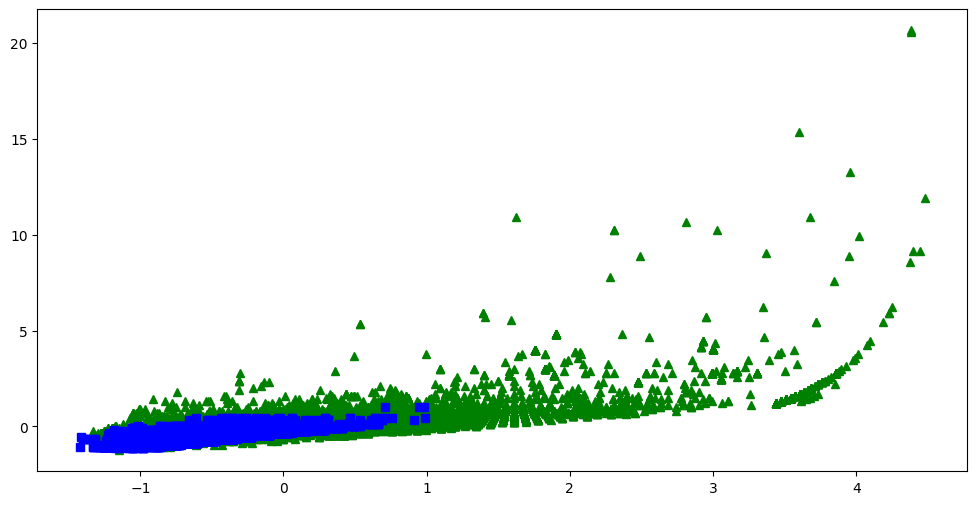

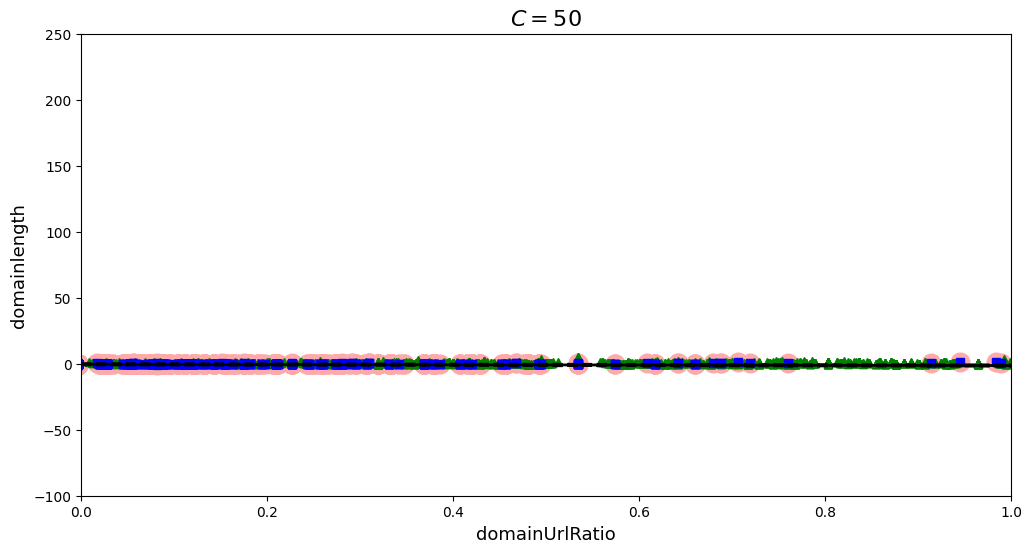

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(X_train_reduced.values[:, 0][y_train=="phishing"], X_train_reduced.values[:, 1][y_train=="phishing"], "g^")
plt.plot(X_train_reduced.values[:, 0][y_train=="benign"], X_train_reduced.values[:, 1][y_train=="benign"], "bs")
plot_svc_decision_boundary(svm_clf, 0, 1)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)
plt.axis([0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainlength", fontsize=13)
plt.show()

**Predicción con un conjunto de datos reducido**

In [54]:
#TODO Predice sobre el subconjunto X_val_reduced

y_val_pred = svm_model.predict(X_val_reduced)

# Mostrar las predicciones
print("Predicciones sobre el conjunto de validación:")
print(y_val_pred)

Predicciones sobre el conjunto de validación:
['benign' 'phishing' 'benign' ... 'phishing' 'phishing' 'benign']


In [55]:
#Comprueba el F1 Score
from sklearn.metrics import f1_score

# Calcular el F1 Score
f1 = f1_score(y_val, y_val_pred, average='weighted')  # 'weighted' toma en cuenta el desbalanceo de clases

print(f"F1 Score: {f1:.4f}")

F1 Score: 0.8324


Como se verá más adelante, para determinados kernels es muy importante escalar el conjunto de datos. En ese caso, para el kernel lineal, no es tan relevante, aunque es posible que proporciones mejores resultados.

In [60]:
# Repite el entrenamiento aplicando RobustScaler() y, después, SVC() en un Pipeline
svm_clf_sc = Pipeline([
        ("scaler", RobustScaler()),
        ("linear_svc", SVC(kernel="linear", C=50)),
    ])

svm_clf_sc.fit(X_train_reduced, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('linear_svc', SVC(C=50, kernel='linear'))])

In [61]:
# TODO Vuelve a predecir a partir de X_val_reduced 
y_val_pred = svm_clf_sc.predict(X_val_reduced)

In [62]:
# TODO Obtén el f1 scoring (aplicar escalado a kernel lineal no influye demasiado, sí lo hará para polinómico o gaussiano)
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Imprimir el F1 Score
print(f"F1 Score con RobustScaler: {f1:.4f}")

F1 Score con RobustScaler: 0.8324


### 5.2 Conjunto de datos completo

In [63]:
from sklearn.svm import SVC
# Entrenamiento con todo el conjunto de datos: SVC(kernel="linear", C=1) para x_train_prep, y_train
svm_model_full = SVC(kernel="linear", C=1)
svm_model_full.fit(X_train_prep, y_train)

SVC(C=1, kernel='linear')

In [64]:
# TODO Vuelve a prededir ahora con X_val_prep
y_val_pred_full = svm_model_full.predict(X_val_prep)

In [66]:
# Obtén el f1 scoring (ahora obtendrás un acierto mayor a 0.95)
f1_full = f1_score(y_val, y_val_pred_full, average='weighted')

# Imprimir el F1 Score
print(f"F1 Score con el conjunto completo: {f1_full:.4f}")

F1 Score con el conjunto completo: 0.9675


## 6. SVM: Kernel no lineal

### 6.1. Polynomial Kernel (I)

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [67]:
# Para representar el límite de decisión tenemos que pasar la variable objetivo a numérica
y_train_num = y_train.factorize()[0]
y_val_num = y_val.factorize()[0]

In [68]:
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
# Después veremos una forma mejor de hacerlo:
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)), # Transforma las caracterísitcas a polinómicas hasta ^3
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=20, loss="hinge", random_state=42, max_iter=100000, dual=True)) # Es lo mismo que kernel="linear"
    ])

polynomial_svm_clf.fit(X_train_reduced, y_train_num)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=20, dual=True, loss='hinge', max_iter=100000,
                           random_state=42))])

**Representación del límite de decisión (ahora será no lineal)**

In [69]:
def plot_dataset(X, y):
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g.")
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "b.")

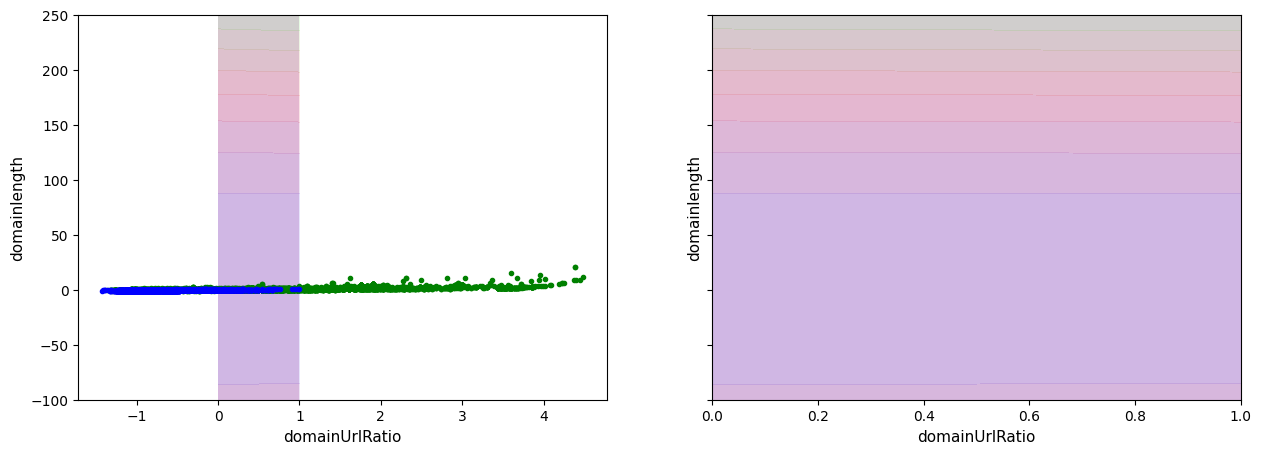

In [70]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Predicción con el conjunto de datos reducido**

In [71]:
#TODO Predice para X_val_reduced
y_val_pred_poly = polynomial_svm_clf.predict(X_val_reduced)

In [73]:
#TODO Obtén el F1 Score
f1_poly = f1_score(y_val_num, y_val_pred_poly, average='weighted')

# Imprimir el F1 Score
print(f"F1 Score con kernel polinómico: {f1_poly:.4f}")

F1 Score con kernel polinómico: 0.8665


### 6.2. Polynomial Kernel (II)

Existe una forma más sencilla de entrenar un algoritmo SVM que utilize polynomial kernel utilizando el parámetro **kernel** de la propia función implementada en sklearn

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [74]:
svm_clf = SVC(kernel="poly", degree=3, coef0=10, C=20)
svm_clf.fit(X_train_reduced, y_train_num)

SVC(C=20, coef0=10, kernel='poly')

**Representación del límite de decisión**

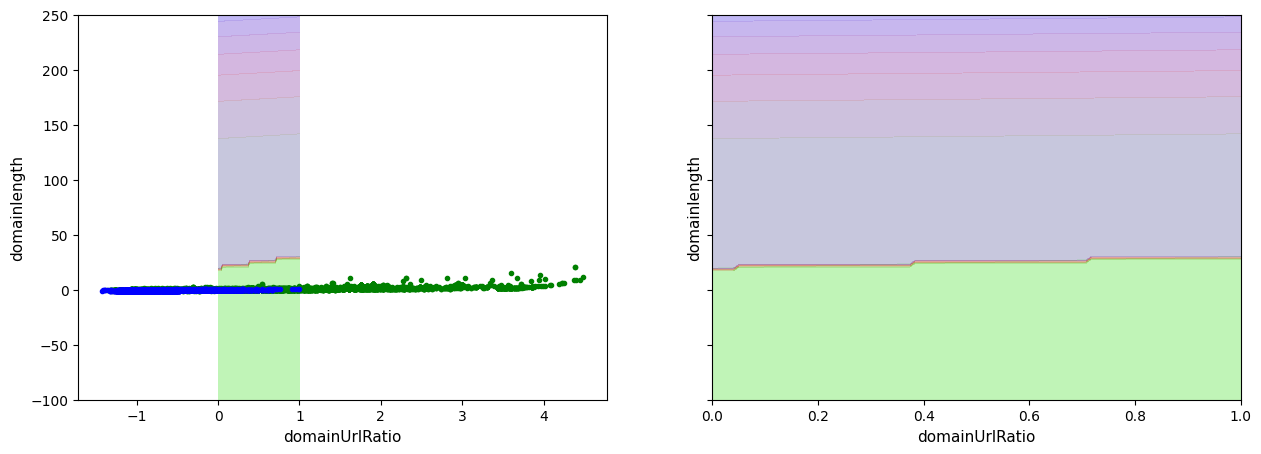

In [75]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Predicción con un conjunto de datos reducido**

In [76]:
#TODO predícelo para X_val_reduced

y_val_pred_poly = svm_clf.predict(X_val_reduced)

In [77]:
#TODO Obtén el F1 Score
f1_poly = f1_score(y_val_num, y_val_pred_poly, average='weighted')

# Imprimir el F1 Score
print(f"F1 Score con kernel polinómico: {f1_poly:.4f}")

F1 Score con kernel polinómico: 0.8664


**Predicción con el conjunto de datos completo**

In [82]:
#TODO entrena SVC con kernel "poly" y, por ejemplo, C=40 para X_train_prep, y_train_num

# Crear el modelo SVM con kernel polinómico
svm_poly_full_clf = SVC(kernel='poly', degree=3, C=40, coef0=10, random_state=42)

# Entrenar el modelo usando el conjunto de entrenamiento completo
svm_poly_full_clf.fit(X_train_prep, y_train_num)


SVC(C=40, coef0=10, kernel='poly', random_state=42)

In [83]:
# Predícelo para X_val_prep
y_val_pred_poly_full = svm_poly_full_clf.predict(X_val_prep)

In [134]:
# Obtén el F1 Score

f1_poly_full = f1_score(y_val_num, y_val_pred_poly_full, average='weighted')

# Imprimir el F1 Score
print(f"F1 Score con kernel polinómico (conjunto completo): {f1_poly_full:.4f}")

F1 Score con kernel polinómico (conjunto completo): 0.9792


### 6.2. Gaussian Kernel

**Entrenamiento del algoritmo con un conjunto de datos reducido**

In [253]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.00001, C=150000))
        ])
rbf_kernel_svm_clf.fit(X_train_reduced, y_train_num)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=150000, gamma=1e-05))])

**Representación del límite de decisión**

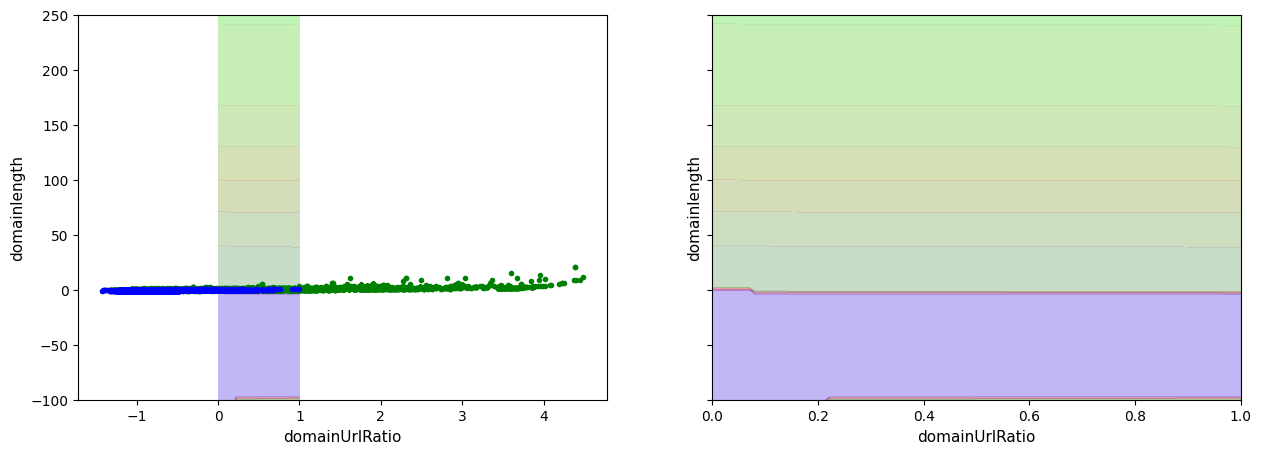

In [254]:
fig, axes = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.sca(axes[1])
plot_predictions(rbf_kernel_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)
plt.show()

**Predicción con un conjunto de datos reducido**

In [255]:
# TODO predícelo para X_val_reduced
y_val_pred_rbf_reduced = rbf_kernel_svm_clf.predict(X_val_reduced)

In [256]:
# TODO obtén el F1 Score
f1_rbf_reduced = f1_score(y_val_num, y_val_pred_rbf_reduced, average='weighted')

# Imprimir el F1 Score
print(f"F1 Score con kernel RBF (conjunto reducido): {f1_rbf_reduced:.4f}")

F1 Score con kernel RBF (conjunto reducido): 0.8056


**Predicción con un conjunto de datos completo**

In [257]:
# Entrena aplicando lo anterior: Pipeline con RobustScaler y SVC(kernel="rbf"). Ahora por ejemplo, cambia gamma a 0.05
# el .fit será sobre X_train_prep, y_train_num
rbf_kernel_svm_clf.fit(X_train_prep, y_train_num)

Pipeline(steps=[('scaler', RobustScaler()),
                ('svm_clf', SVC(C=150000, gamma=1e-05))])

In [258]:
# TODO predícelo para X_val_prep
y_val_pred_rbf_full = rbf_kernel_svm_clf.predict(X_val_prep)

In [259]:
# TODO obtén el F1 Score
f1_rbf_full = f1_score(y_val_num, y_val_pred_rbf_full, average='weighted')

# Imprimir el F1 Score
print(f"F1 Score: {f1_rbf_full:.4f}")
f1_rbf_full

F1 Score: 0.9813


np.float64(0.9813450920025233)

In [260]:
# ¿Cuál ha sido tu mejor F1 Score? ¿Con qué configuración de kernel, gamma y C? Debería ser entre 0.96 y 0.98

# rbf_kernel_svm_clf = Pipeline([
#            ("scaler", RobustScaler()),
#            ("svm_clf", SVC(kernel="rbf", gamma=0.00001, C=150000))
        ])
# np.float64(0.9813450920025233)

In [261]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.001, C=1000))
        ])
# F1 Score: 0.9787

In [210]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.001, C=10000))
        ])
# F1 Score: 0.9783

In [ ]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.0001, C=10000))
        ])
# F1 Score: 0.9800

In [ ]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.00001, C=10000))
        ])
# np.float64(0.9800436393812774)

In [ ]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.00001, C=100000))
        ])
# np.float64(0.9809113072342655)

In [ ]:
rbf_kernel_svm_clf = Pipeline([
            ("scaler", RobustScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=0.00001, C=150000))
        ])
# np.float64(0.9813450920025233)